In [14]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')#使用ggplot样式
%matplotlib inline

In [3]:
from sagas.ofbiz.entities import oc,finder,OfEntity, MetaEntity
from sagas.ofbiz.services import OfService
OfEntity().getProductType(productTypeId="Test_type_2")

{'lastUpdatedStamp': JavaObject id=o38, 'isPhysical': None, 'parentTypeId': None, 'isDigital': None, 'hasTable': None, 'createdTxStamp': JavaObject id=o39, 'createdStamp': JavaObject id=o40, 'description': None, 'lastUpdatedTxStamp': JavaObject id=o41, 'productTypeId': 'Test_type_2'}

```xml
<ProductPrice productId="DemoProduct-1" productPricePurposeId="PURCHASE" productPriceTypeId="DEFAULT_PRICE" currencyUomId="USD" productStoreGroupId="_NA_" fromDate="2006-05-13 12:00:00.0" price="15.00" createdDate="2006-05-13 12:00:00.0"  lastModifiedDate="2006-05-13 12:00:00.0"/>
```

In [26]:
import pyarrow as pa

records=OfEntity().listProductPrice()
products=[]
price_purposes=[]
price_types=[]
prices=[]

for rec in records:
    type_id=rec['productPriceTypeId']
    if type_id=="DEFAULT_PRICE":
        products.append(rec['productId'])
        price_purposes.append(rec['productPricePurposeId'])
        price_types.append(type_id)
        prices.append(float(rec['price']))

data = [
    pa.array(products),
    pa.array(price_purposes),
    pa.array(price_types),
    pa.array(prices)
]
batch = pa.RecordBatch.from_arrays(data, ['product', 'purpose', 'type', 'price'])
batches = [batch] 
table = pa.Table.from_batches(batches)
print(table, table.num_rows, table.num_columns)

pyarrow.Table
product: string
purpose: string
type: string
price: double 8 4


In [27]:
tables = [table] 
table_all = pa.concat_tables(tables)
print(table_all.num_rows)

df_new = table_all.to_pandas()
# df_new.head()
df_new[:20]

8


,product,purpose,type,price
0,BoatRowSimple,PURCHASE,DEFAULT_PRICE,549.99
1,Cap,PURCHASE,DEFAULT_PRICE,5.99
2,CFSV1001,PURCHASE,DEFAULT_PRICE,9.99
3,CPU-586,COMPONENT_PRICE,DEFAULT_PRICE,250.00
4,DemoProduct-1,PURCHASE,DEFAULT_PRICE,15.00
5,DemoProduct-2,PURCHASE,DEFAULT_PRICE,5.00
6,DemoProduct-3,PURCHASE,DEFAULT_PRICE,10.00
7,DOUGH,COMPONENT_PRICE,DEFAULT_PRICE,3.00


In [19]:
df_new.iloc[3]

product            CPU-586
purpose    COMPONENT_PRICE
type         DEFAULT_PRICE
price              250.000
Name: 3, dtype: object

In [24]:
df_new['price']

0    549.990
1      5.990
2      9.990
3    250.000
4     15.000
5      5.000
6     10.000
7      3.000
Name: price, dtype: object

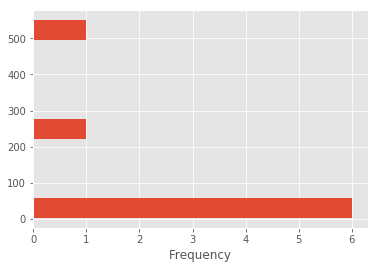

In [29]:
plt.figure();
# df_new['price'].plot.hist(orientation='horizontal', cumulative=True)
df_new['price'].plot.hist(orientation='horizontal', cumulative=False)

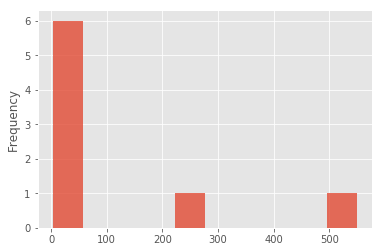

In [34]:
plt.figure()
df_new['price'].plot.hist(alpha=0.8)

In [5]:
product=MetaEntity("Product").record("GZ-2002")
ok, ret=OfService().calculateProductPrice(product=product)
print(ret['defaultPrice'], ret['listPrice'])
print(ret)

47.990 48.000
{'defaultPrice': Decimal('47.990'), 'currencyUsed': 'USD', 'price': Decimal('47.990'), 'orderItemPriceInfos': [], 'specialPromoPrice': None, 'isSale': False, 'validPriceFound': True, 'averageCost': Decimal('48.000'), 'competitivePrice': None, 'listPrice': Decimal('48.000'), 'basePrice': Decimal('47.990')}


In [46]:
def get_product_price(product_id):
    product=MetaEntity("Product").record(product_id)
    ok, ret=OfService().calculateProductPrice(product=product)
    return ret
def pickup(record, fields):
    result=[]
    for fld in fields:
        result.append(float(record[fld]) if record[fld] is not None else 0.0)
    return result

fields=["defaultPrice", "price", "averageCost", "listPrice", "basePrice"]

product_1_id="GZ-2002"
product_1=get_product_price(product_1_id)
product_2_id="DemoProduct-2"
product_2=get_product_price(product_2_id)
df = pd.DataFrame({product_1_id: pickup(product_1, fields), 
                  product_2_id: pickup(product_2, fields)}, 
                  columns=[product_1_id, product_2_id])
df.head()

,GZ-2002,DemoProduct-2
0,47.99,5.0
1,47.99,5.0
2,48.00,0.0
3,48.00,0.0
4,47.99,5.0


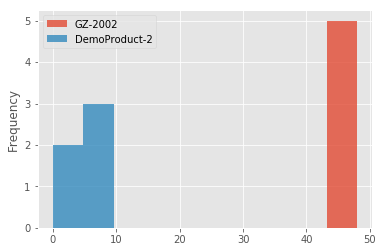

In [47]:
plt.figure()
df.plot.hist(alpha=0.8)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11531cd30>,
      dtype=object)

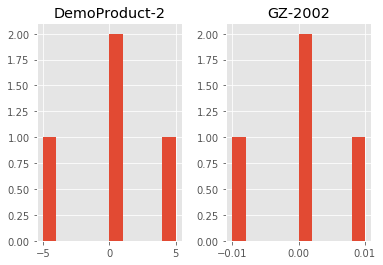

In [48]:
df.diff().hist()

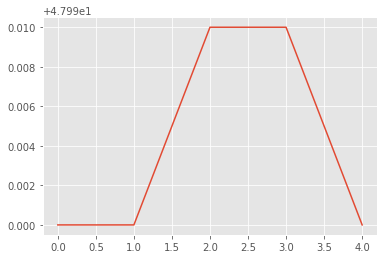

In [49]:
df['GZ-2002'].plot()

In [78]:
import datetime
from datetime import date
import time
from datetime import timedelta

print(datetime.date(2018, 12, 31))
print(time.time())
print(date.fromtimestamp(time.time()))
print(datetime.datetime.fromtimestamp(time.time()))
print(datetime.datetime.fromtimestamp(1548508174854/1000))

year = timedelta(days=365)
hundred_years = 100 * year
default_thru=date.today()+hundred_years
print(default_thru)

2018-12-31
1549370650.007912
2019-02-05
2019-02-05 20:44:10.008156
2019-01-26 21:09:34.854000
2119-01-12


In [60]:
ent=MetaEntity("ProductPrice")
field_names=model.field_names

In [87]:
import pyarrow as pa

records=OfEntity().listProductPrice()
data=[]
skip_fields=['lastModifiedDate']
pnames=[]
for fld in field_names:
    if fld not in skip_fields:
        pnames.append(fld)
        
        field_arr=[]
        model_fld=ent.model.getField(fld)
        fld_type=model_fld.getType()
        # print('- ', fld, fld_type)    
        for rec in records:
            val=rec[fld]
            if val is None:
                if fld=='thruDate':
                    val=default_thru                
            elif fld_type=='date-time':
                time_ms=rec[fld].getTime()
                val=datetime.datetime.fromtimestamp(time_ms/1000)
            
            field_arr.append(val)
        data.append(pa.array(field_arr))
        
batch = pa.RecordBatch.from_arrays(data, pnames)
batches = [batch] 
table = pa.Table.from_batches(batches)
print(table, table.num_rows, table.num_columns)

pyarrow.Table
taxInPrice: null
termUomId: null
priceWithTax: null
createdStamp: timestamp[us]
productStoreGroupId: string
taxAuthPartyId: null
lastModifiedByUserLogin: string
customPriceCalcService: null
price: decimal(6, 3)
taxAuthGeoId: null
productPricePurposeId: string
createdByUserLogin: string
lastUpdatedStamp: timestamp[us]
productId: string
createdTxStamp: timestamp[us]
taxPercentage: null
lastUpdatedTxStamp: timestamp[us]
thruDate: date32[day]
fromDate: timestamp[us]
currencyUomId: string
createdDate: timestamp[us]
priceWithoutTax: null
taxAmount: null
productPriceTypeId: string 10 24


In [88]:
df= table.to_pandas()
df.head()

,taxInPrice,termUomId,priceWithTax,createdStamp,productStoreGroupId,taxAuthPartyId,lastModifiedByUserLogin,customPriceCalcService,price,taxAuthGeoId,...,createdTxStamp,taxPercentage,lastUpdatedTxStamp,thruDate,fromDate,currencyUomId,createdDate,priceWithoutTax,taxAmount,productPriceTypeId
0,None,None,None,2019-01-26 21:09:34.854,_NA_,None,admin,None,922.000,None,...,2019-01-26 21:09:34.661,None,2019-01-26 21:09:34.661,2119-01-12,2001-05-13 12:00:00.000,EUR,2001-05-13 12:00:00,None,None,COMPETITIVE_PRICE
1,None,None,None,2019-01-26 21:09:34.852,_NA_,None,admin,None,549.990,None,...,2019-01-26 21:09:34.661,None,2019-01-26 21:09:34.661,2119-01-12,2001-05-13 12:00:00.000,EUR,2001-05-13 12:00:00,None,None,DEFAULT_PRICE
2,None,None,None,2019-01-26 21:09:34.853,_NA_,None,admin,None,550.000,None,...,2019-01-26 21:09:34.661,None,2019-01-26 21:09:34.661,2119-01-12,2001-05-13 12:00:00.000,EUR,2001-05-13 12:00:00,None,None,LIST_PRICE
3,None,None,None,2019-01-26 21:09:34.855,_NA_,None,admin,None,5.990,None,...,2019-01-26 21:09:34.661,None,2019-01-26 21:09:34.661,2119-01-12,2003-03-04 18:50:45.250,EUR,2001-05-13 12:00:00,None,None,DEFAULT_PRICE
4,None,None,None,2019-01-26 21:09:27.253,_NA_,None,None,None,9.990,None,...,2019-01-26 21:09:22.215,None,2019-01-26 21:09:22.215,2119-01-12,2011-08-02 12:00:00.000,USD,2011-08-02 12:00:00,None,None,DEFAULT_PRICE


In [3]:
import pandas as pd
df = pd.DataFrame({"id":[1,2,3,4,5,6], "raw_grade":['a', 'b', 'b', 'a', 'a', 'e']})
df

,id,raw_grade
0,1,a
1,2,b
2,3,b
3,4,a
4,5,a
5,6,e


In [9]:
from sagas.ofbiz.entities import oc,finder,OfEntity, MetaEntity
from sagas.ofbiz.services import OfService
ent=MetaEntity("ProductPrice")
model_desc={'name':[str(fld.getName()) for fld in ent.model.getFieldsIterator()], 
            'type':[str(fld.getType()) for fld in ent.model.getFieldsIterator()], 
            'primary': ['*' if fld.getIsPk() else ' '  for fld in ent.model.getFieldsIterator()]
           }
df = pd.DataFrame(model_desc)
df

,name,primary,type
0,productId,*,id
1,productPriceTypeId,*,id
2,productPricePurposeId,*,id
3,currencyUomId,*,id
4,productStoreGroupId,*,id
5,fromDate,*,date-time
6,thruDate,,date-time
7,price,,currency-precise
8,termUomId,,id
9,customPriceCalcService,,id


In [19]:
from sagas.ofbiz.entities import oc,finder,OfEntity, MetaEntity
from sagas.ofbiz.services import OfService

def create_data_frame(ent_name):
    ent=MetaEntity(ent_name)
    model_desc={'name':[str(fld.getName()) for fld in ent.model.getFieldsIterator()], 
                'type':[str(fld.getType()) for fld in ent.model.getFieldsIterator()], 
                'primary': ['*' if fld.getIsPk() else ' '  for fld in ent.model.getFieldsIterator()]
               }
    df = pd.DataFrame(model_desc)
    df['field type']=df['type'].astype('category')
    # df.sort_values(by='field type')
    return df

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
name       25 non-null object
primary    25 non-null object
type       25 non-null object
dtypes: object(3)
memory usage: 680.0+ bytes


In [11]:
df['field type']=df['type'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
name          25 non-null object
primary       25 non-null object
type          25 non-null object
field type    25 non-null category
dtypes: category(1), object(3)
memory usage: 913.0+ bytes


In [12]:
df

,name,primary,type,field type
0,productId,*,id,id
1,productPriceTypeId,*,id,id
2,productPricePurposeId,*,id,id
3,currencyUomId,*,id,id
4,productStoreGroupId,*,id,id
5,fromDate,*,date-time,date-time
6,thruDate,,date-time,date-time
7,price,,currency-precise,currency-precise
8,termUomId,,id,id
9,customPriceCalcService,,id,id


In [13]:
df.sort_values(by='field type')

,name,primary,type,field type
12,taxAmount,,currency-precise,currency-precise
11,priceWithTax,,currency-precise,currency-precise
7,price,,currency-precise,currency-precise
10,priceWithoutTax,,currency-precise,currency-precise
22,lastUpdatedTxStamp,,date-time,date-time
21,lastUpdatedStamp,,date-time,date-time
19,lastModifiedDate,,date-time,date-time
17,createdDate,,date-time,date-time
23,createdStamp,,date-time,date-time
24,createdTxStamp,,date-time,date-time


In [14]:
df.groupby("field type").size()

field type
currency-precise    4
date-time           8
fixed-point         1
id                  9
id-vlong            2
indicator           1
dtype: int64

In [17]:
from sagas.ofbiz.entities import search_entity
search_entity('product')

SupplierProductFeature
ProductStoreKeywordOvrd
ProductPricePurpose
ProductConfigOption
ProductCategoryRole
ProductConfigOptionIactn
ProductFacilityLocation
ProductStoreCatalog
SupplierProductAndProduct
OrderReportPurchasesGroupByProduct
OrderItemAndProductContentInfo
ProductStore
ProductPrice
ProductFeatureGroupAndAppl
ProductPriceAction
ProductPromo
ProductContentAndInfo
ConfigOptionProductOption
ProductFeaturePrice
ProductStoreRole
ProductStoreEmailSetting
ProductStoreGroupRollup
ProductCategoryContentType
OrderItemAndProduct
ProductAndAssoc
ProductPromoCategory
ProductCategoryAndMember
ContentApprovalProductContentAndInfo
ProductFeatureAndAppl
ProductAverageCost
ProductStoreFacility
ProductFeatureCategoryAppl
ProductFeatureIactnType
ProductKeyword
ProductPromoCodeParty
ProductStorePromoAppl
OrderHeaderAndShipGroupsByProduct
ProductGlAccount
ProductCategoryLink
ProductFacilityAndPostalAddress
ProductPromoAction
ProductPriceChange
ProductType
ProductFeatureCatGrpAppl
ProductReview
Pro

In [18]:
df_ent=create_data_frame('ProductAndCategoryMember')
df_ent

,name,primary,type,field type
0,memberComments,,comment,comment
1,originGeoId,,id,id
2,detailScreen,,long-varchar,long-varchar
3,requireInventory,,indicator,indicator
4,quantityUomId,,id,id
5,mediumImageUrl,,url,url
6,productName,,name,name
7,introductionDate,,date-time,date-time
8,shippingHeight,,fixed-point,fixed-point
9,originalImageUrl,,url,url


In [20]:
df.sort_values(by='name')

,name,primary,type,field type
18,createdByUserLogin,,id-vlong,id-vlong
17,createdDate,,date-time,date-time
23,createdStamp,,date-time,date-time
24,createdTxStamp,,date-time,date-time
3,currencyUomId,*,id,id
9,customPriceCalcService,,id,id
5,fromDate,*,date-time,date-time
20,lastModifiedByUserLogin,,id-vlong,id-vlong
19,lastModifiedDate,,date-time,date-time
21,lastUpdatedStamp,,date-time,date-time


In [30]:
from sagas.ofbiz.services import OfService, MetaService
from py4j.java_gateway import get_field

def create_service_data_frame(name):
    model=MetaService(name).model
    params=model.getModelParamList()
    model_desc={'name':[str(get_field(param, "name")) for param in params],
                'type':[str(get_field(param, "type")) for param in params],
                'primary': ['*' if not get_field(param, "optional") else ' '  for param in params],
                'entity name': [str(get_field(param, "entityName")) for param in params],
                'mode':[str(get_field(param, "mode")) for param in params],
                'description':[str(get_field(param, "description")) for param in params]
               }
    df = pd.DataFrame(model_desc)
    df['parameter mode']=df['mode'].astype('category')
    # return df.sort_values(by='parameter mode')
    return df

create_service_data_frame('calculateProductPrice')

,description,entity name,mode,name,primary,type,parameter mode
0,,,IN,product,*,org.apache.ofbiz.entity.GenericValue,IN
1,,,IN,prodCatalogId,,String,IN
2,,,IN,webSiteId,,String,IN
3,,,IN,partyId,,String,IN
4,,,IN,productStoreId,,String,IN
5,,,IN,productStoreGroupId,,String,IN
6,,,IN,agreementId,,String,IN
7,,,IN,quantity,,BigDecimal,IN
8,,,IN,amount,,BigDecimal,IN
9,,,IN,currencyUomId,,String,IN


In [33]:
def create_relation_data_frame(ent_name):
    ent=MetaEntity(ent_name)
    rels=ent.model.getRelationsList(True, True, True)
    model_desc={'entity name':[str(fld.getRelEntityName()) for fld in rels], 
                'type':[str(fld.getType()) for fld in rels], 
                'relation':[rel.getTitle()+rel.getRelEntityName() for rel in rels]
               }
    df = pd.DataFrame(model_desc)
    df['relation type']=df['type'].astype('category')
    # df.sort_values(by='field type')
    return df

create_relation_data_frame("Product")

,entity name,relation,type,relation type
0,ProductType,ProductType,one,one
1,ProductTypeAttr,ProductTypeAttr,many,many
2,ProductCategory,PrimaryProductCategory,one,one
3,Facility,Facility,one,one
4,Uom,QuantityUom,one,one
5,UomType,AmountUomType,one,one
6,Uom,WeightUom,one,one
7,Uom,HeightUom,one,one
8,Uom,WidthUom,one,one
9,Uom,DepthUom,one,one
